In [1]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle
import numpy as np

beni=pd.read_csv('./HealthClaims/Train_Beneficiarydata-1542865627584.csv')
inpai=pd.read_csv('./HealthClaims/Train_Inpatientdata-1542865627584.csv')
outpai=pd.read_csv('./HealthClaims/Train_Outpatientdata-1542865627584.csv')
fraud=pd.read_csv('./HealthClaims/Train-1542865627584.csv')

In [2]:
columns_to_drop=['AdmissionDt','DischargeDt','DiagnosisGroupCode']
newinpai=inpai.drop(columns=columns_to_drop)

In [3]:
newInOutPai=pd.concat([newinpai,outpai],axis=0)

In [4]:
newInOutPaiWithFraud=pd.merge(newInOutPai,fraud,on='Provider',how='left')
newInOutPaiWithFraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 28 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   BeneID                  558211 non-null  object 
 1   ClaimID                 558211 non-null  object 
 2   ClaimStartDt            558211 non-null  object 
 3   ClaimEndDt              558211 non-null  object 
 4   Provider                558211 non-null  object 
 5   InscClaimAmtReimbursed  558211 non-null  int64  
 6   AttendingPhysician      556703 non-null  object 
 7   OperatingPhysician      114447 non-null  object 
 8   OtherPhysician          199736 non-null  object 
 9   ClmAdmitDiagnosisCode   145899 non-null  object 
 10  DeductibleAmtPaid       557312 non-null  float64
 11  ClmDiagnosisCode_1      547758 non-null  object 
 12  ClmDiagnosisCode_2      362605 non-null  object 
 13  ClmDiagnosisCode_3      243055 non-null  object 
 14  ClmDiagnosisCode_4  

In [5]:
dfN=pd.merge(beni,newInOutPaiWithFraud,on='BeneID',how='left')
dfN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 52 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   DOB                              558211 non-null  object 
 2   DOD                              4131 non-null    object 
 3   Gender                           558211 non-null  int64  
 4   Race                             558211 non-null  int64  
 5   RenalDiseaseIndicator            558211 non-null  object 
 6   State                            558211 non-null  int64  
 7   County                           558211 non-null  int64  
 8   NoOfMonths_PartACov              558211 non-null  int64  
 9   NoOfMonths_PartBCov              558211 non-null  int64  
 10  ChronicCond_Alzheimer            558211 non-null  int64  
 11  ChronicCond_Heartfailure         558211 non-null  int64  
 12  Ch

In [6]:
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import pickle

df8 = dfN.dropna(thresh=len(dfN) * 0.5, axis=1)
df9 = df8

X = df8.drop(columns=['InscClaimAmtReimbursed', 'Provider'])
y = df8['InscClaimAmtReimbursed']

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, X.select_dtypes(include=['int', 'float']).columns),
        ('cat', categorical_transformer, X.select_dtypes(include=['object']).columns)
    ])

X_preprocessed = preprocessor.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(n_estimators=100, max_depth=5, learning_rate=0.1, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE:", mse)
print("RMSE:", np.sqrt(mse))


MSE: 2902652.3807902755
RMSE: 1703.7172244214341


In [7]:
from sklearn.metrics import r2_score
import numpy as np

r2 = r2_score(y_test, y_pred)
print("R^2 Score:", r2)

n = X_test.shape[0]  
p = X_test.shape[1]  
adjusted_r2 = 1 - (1 - r2) * (n - 1) / (n - p - 1)
print("Adjusted R^2 Score:", adjusted_r2)


R^2 Score: 0.7962289420360686
Adjusted R^2 Score: 1.0332288607144453


In [8]:
from joblib import dump
dump(preprocessor, './HealthClaims/healthcare_preprocessor.joblib')
from joblib import load

In [9]:
with open('./HealthClaims/RfPickelModelx1.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

In [10]:
import pandas as pd
import pickle

model_filename = './HealthClaims/RfPickelModelx1.pkl'
with open(model_filename, 'rb') as model_file:
    loaded_model = pickle.load(model_file)

df7=dfN
first_row = df7.iloc[[44]]  
X_first_row_preprocessed = preprocessor.transform(first_row)

predicted_value = loaded_model.predict(X_first_row_preprocessed)

actual_value = df7.iloc[44]['InscClaimAmtReimbursed']

print("Predicted Value:", predicted_value)
print("Actual Value:", actual_value)

Predicted Value: [387.66434]
Actual Value: 200


In [11]:
import pandas as pd

data = dfN

modes = data.mode()

modes_dict = {}

for col in modes.columns:
    mode_val = modes[col][0]  
    modes_dict[col] = [mode_val]  
modes_df = pd.DataFrame(modes_dict)

modes_df.to_csv('./HealthClaims/newmode1.csv', index=False)

print("Modes of each column have been saved to 'column_modes.csv' file.")

Modes of each column have been saved to 'column_modes.csv' file.


In [12]:
import pandas as pd

df0=dfN

print("Columns before dropping:")
print(df0.columns)

dropped_columns = df0.columns[df0.isnull().mean() > 0.5]



print("\nColumns dropped:")
print(dropped_columns)

Columns before dropping:
Index(['BeneID', 'DOB', 'DOD', 'Gender', 'Race', 'RenalDiseaseIndicator',
       'State', 'County', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov',
       'ChronicCond_Alzheimer', 'ChronicCond_Heartfailure',
       'ChronicCond_KidneyDisease', 'ChronicCond_Cancer',
       'ChronicCond_ObstrPulmonary', 'ChronicCond_Depression',
       'ChronicCond_Diabetes', 'ChronicCond_IschemicHeart',
       'ChronicCond_Osteoporasis', 'ChronicCond_rheumatoidarthritis',
       'ChronicCond_stroke', 'IPAnnualReimbursementAmt',
       'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt',
       'OPAnnualDeductibleAmt', 'ClaimID', 'ClaimStartDt', 'ClaimEndDt',
       'Provider', 'InscClaimAmtReimbursed', 'AttendingPhysician',
       'OperatingPhysician', 'OtherPhysician', 'ClmAdmitDiagnosisCode',
       'DeductibleAmtPaid', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
       'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5',
       'ClmDiagnosisCode_6', 'ClmDiagnosisCo

In [ ]:
import seaborn as sns

numerical_columns = df9.select_dtypes(include=['int', 'float'])

correlation_matrix = numerical_columns.corr()

correlation_with_target = correlation_matrix['InscClaimAmtReimbursed']

print(correlation_with_target)

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")


Gender                            -0.002094
Race                              -0.000477
State                              0.000208
County                            -0.001029
NoOfMonths_PartACov               -0.005551
NoOfMonths_PartBCov               -0.005824
ChronicCond_Alzheimer             -0.034013
ChronicCond_Heartfailure          -0.058602
ChronicCond_KidneyDisease         -0.097151
ChronicCond_Cancer                -0.026543
ChronicCond_ObstrPulmonary        -0.068528
ChronicCond_Depression            -0.017902
ChronicCond_Diabetes              -0.044934
ChronicCond_IschemicHeart         -0.052348
ChronicCond_Osteoporasis          -0.010454
ChronicCond_rheumatoidarthritis   -0.017377
ChronicCond_stroke                -0.048768
IPAnnualReimbursementAmt           0.383701
IPAnnualDeductibleAmt              0.225477
OPAnnualReimbursementAmt           0.064411
OPAnnualDeductibleAmt              0.030561
InscClaimAmtReimbursed             1.000000
DeductibleAmtPaid               

<Axes: >

<Axes: >

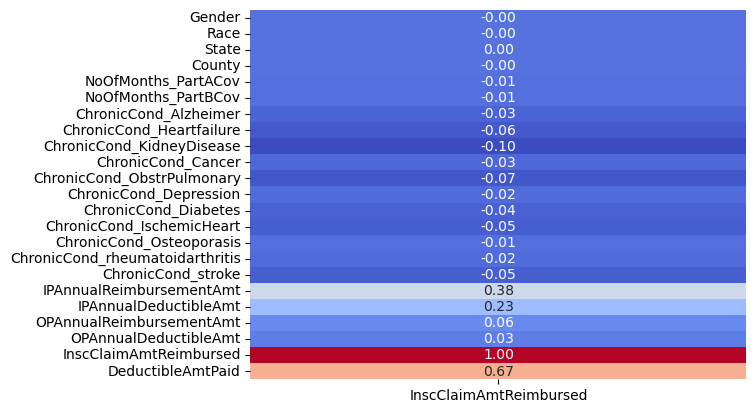

In [17]:
import seaborn as sns

numerical_columns = df9.select_dtypes(include=['int', 'float'])

correlation_matrix = numerical_columns.corr()

sns.heatmap(correlation_matrix[['InscClaimAmtReimbursed']], annot=True, cmap='coolwarm', fmt=".2f", cbar=False)
